In [ ]:
%pip install -r requirements.txt
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import tarfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [53]:
# folder_path = "data"
folder_path = "data_small"

In [54]:
def unarchive_and_read_tsv(prefix, tsv_filename):
    file_to_unarchive = None
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tar.gz') and file_name.startswith(prefix):
            file_to_unarchive = os.path.join(folder_path, file_name)
            break

    if file_to_unarchive is None:
        print(f"No matching .tar.gz file found with prefix '{prefix}'.")
        return None

    archive_name = os.path.basename(file_to_unarchive)[:-7]
    unarchived_folder = os.path.join(folder_path, archive_name)
    if os.path.exists(unarchived_folder):
        print("File already unarchived.")
    else:
        with tarfile.open(file_to_unarchive, 'r:gz') as tar:
            tar.extractall(unarchived_folder)
        print("File unarchived successfully.")

    tsv_file = os.path.join(unarchived_folder, tsv_filename)
    dataframe = pd.read_csv(tsv_file, delimiter='\t')
    return dataframe


In [55]:
prefix = "clinical"
tsv_filename = "clinical.tsv"

clinical_df = unarchive_and_read_tsv(prefix, tsv_filename)

# Remove duplicate rows based on 'case_id' column
print(f'Shape before deduplication: {clinical_df.shape}')
clinical_df = clinical_df.drop_duplicates(subset='case_id', keep='first')
print(f'Shape after deduplication: {clinical_df.shape}')

if clinical_df is not None:
    print(clinical_df.head())

File already unarchived.
Shape before deduplication: (80, 158)
Shape after deduplication: (40, 158)
                                case_id case_submitter_id project_id   
0  0078b0c4-68a9-483b-9aab-61156d263213      TCGA-14-1034   TCGA-GBM  \
2  054f472f-98cb-4559-b2e2-b5f800fc8eef      TCGA-06-0221   TCGA-GBM   
4  153c2442-ea61-4b5e-8c5c-c71d287c6055      TCGA-28-5209   TCGA-GBM   
6  1e80ccf6-ef81-4662-bf5e-392f092c1e67      TCGA-41-2572   TCGA-GBM   
8  1f48f010-98fe-4b5a-b96a-14fb25eff23f      TCGA-06-0184   TCGA-GBM   

   age_at_index age_is_obfuscated cause_of_death cause_of_death_source   
0            60               '--            '--                   '--  \
2            31               '--            '--                   '--   
4            66               '--            '--                   '--   
6            67               '--            '--                   '--   
8            63               '--            '--                   '--   

  country_of_residence

(array([2., 0., 4., 2., 6., 8., 7., 6., 2., 3.]),
 array([30. , 35.5, 41. , 46.5, 52. , 57.5, 63. , 68.5, 74. , 79.5, 85. ]),
 <BarContainer object of 10 artists>)

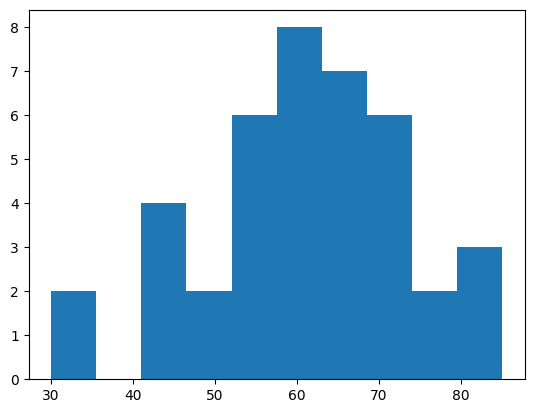

In [56]:
# extarcting the age column
age = clinical_df['age_at_index']
plt.hist(age, bins=10)

In [57]:
def parse_tsv_file(file_path):
    dataframe = pd.read_csv(file_path, delimiter='\t', comment='#')
    dataframe = dataframe[dataframe['gene_id'].str.startswith('ENSG')]
    dataframe = dataframe[['gene_id', 'tpm_unstranded']]
    dataframe = dataframe.set_index('gene_id').T
    return dataframe

In [58]:
def unarchive_and_build_dataframe(folder_path, prefix):
    file_to_unarchive = None
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tar.gz') and file_name.startswith(prefix):
            file_to_unarchive = os.path.join(folder_path, file_name)
            break

    if file_to_unarchive is None:
        print(f"No matching .tar.gz file found with prefix '{prefix}'.")
        return None

    archive_name = os.path.basename(file_to_unarchive)[:-7]
    unarchived_folder = os.path.join(folder_path, archive_name)
    if os.path.exists(unarchived_folder):
        print("File already unarchived.")
    else:
        with tarfile.open(file_to_unarchive, 'r:gz') as tar:
            tar.extractall(unarchived_folder)
        print("File unarchived successfully.")

    dataframes = []
    for folder_name in os.listdir(unarchived_folder):
        folder_path = os.path.join(unarchived_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue
        tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]
        if len(tsv_files) == 1:
            tsv_file = os.path.join(folder_path, tsv_files[0])
            dataframe = parse_tsv_file(tsv_file)
            dataframes.append(dataframe)

    if not dataframes:
        print("No .tsv files found.")
        return None

    combined_dataframe = pd.concat(dataframes, ignore_index=True)
    return combined_dataframe


In [66]:
prefix = "gdc_download"
data = None
data = unarchive_and_build_dataframe(folder_path, prefix)
# remove the first column
data = data.iloc[:, 1:]
print(data)

File already unarchived.
gene_id  ENSG00000000005.6  ENSG00000000419.13  ENSG00000000457.14   
0                   0.4599            112.2372              8.4532  \
1                   0.5011             77.8868              4.8894   
2                   0.1334             80.0162              4.8043   
3                   0.3367             71.0517              4.1566   
4                   0.3029             68.5263              3.0529   
5                 212.6327             85.4885              8.0810   
6                   0.1890             74.3497              6.2505   
7                   0.1187             72.6344              6.1586   
8                   0.2112             68.6202              5.7166   
9                   0.4192             67.9240              4.0992   
10                  7.0286             84.6279              5.7158   
11                  0.2503             87.9180              9.8774   
12                  1.3449            109.0662              4.286

In [60]:
print(data)

gene_id  ENSG00000000003.15  ENSG00000000005.6  ENSG00000000419.13   
0                   69.5439             0.4599            112.2372  \
1                   44.1409             0.5011             77.8868   
2                   81.7969             0.1334             80.0162   
3                  178.1864             0.3367             71.0517   
4                   96.0510             0.3029             68.5263   
5                   76.9722           212.6327             85.4885   
6                   65.4239             0.1890             74.3497   
7                   81.2876             0.1187             72.6344   
8                   40.8302             0.2112             68.6202   
9                   90.9708             0.4192             67.9240   
10                 128.4459             7.0286             84.6279   
11                  72.2196             0.2503             87.9180   
12                 128.5592             1.3449            109.0662   
13                 1

In [62]:
data

gene_id,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
0,69.5439,0.4599,112.2372,8.4532,8.4303,19.1823,7.8015,62.8843,19.1064,31.7049,...,0.0,3.2324,1.0380,0.0,0.0000,0.0000,10.7866,0.0,0.0202,2.9438
1,44.1409,0.5011,77.8868,4.8894,4.2000,30.4433,25.3965,52.9444,13.4404,18.1856,...,0.0,0.0000,0.5321,0.0,0.0000,0.0000,6.6311,0.0,0.0231,1.7611
2,81.7969,0.1334,80.0162,4.8043,2.8904,26.2095,12.3576,57.4271,12.6304,19.3338,...,0.0,0.0000,0.9901,0.0,0.0000,0.0000,7.5160,0.0,0.0409,1.7184
3,178.1864,0.3367,71.0517,4.1566,2.2713,8.3336,38.9304,37.4083,10.7585,19.9138,...,0.0,0.0000,0.5232,0.0,0.0000,0.0000,8.5254,0.0,0.0221,1.5635
4,96.0510,0.3029,68.5263,3.0529,3.5947,18.5736,12.6479,108.6826,22.7616,23.0231,...,0.0,0.0000,0.1569,0.0,0.0000,0.0000,10.6391,0.0,0.0000,1.9294
5,76.9722,212.6327,85.4885,8.0810,4.7098,17.7154,361.2061,65.8965,6.6777,46.7500,...,0.0,0.0000,0.2305,0.0,0.0000,0.0000,13.3304,0.0,0.0546,0.9906
6,65.4239,0.1890,74.3497,6.2505,6.1436,15.5249,4.1592,35.9265,20.5187,30.7931,...,0.0,0.0000,0.8565,0.0,0.0000,0.0175,8.9138,0.0,0.0072,3.3204
7,81.2876,0.1187,72.6344,6.1586,6.8217,10.7471,5.0596,50.8361,15.6912,34.6560,...,0.0,0.0000,0.4303,0.0,0.0000,0.0000,8.3365,0.0,0.0000,1.9810
8,40.8302,0.2112,68.6202,5.7166,2.7408,27.5078,50.3817,33.2978,10.7589,13.4732,...,0.0,0.0000,1.1484,0.0,0.0000,0.0000,10.6072,0.0,0.0648,3.1074
9,90.9708,0.4192,67.9240,4.0992,2.8605,23.1985,5.6137,45.6936,13.0025,13.8005,...,0.0,0.0000,0.3366,0.0,0.0000,0.0000,5.9581,0.0,0.0515,1.5100


In [63]:
def train_xgboost_model(data, clinical_df):
    # Ignore the first column "gene_id"
    features = data.iloc[:, 1:]
    target = clinical_df['age_at_index']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Train an XGBoost regression model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    return model

In [64]:
print(data.shape)
print(clinical_df.shape)
model = train_xgboost_model(data, clinical_df)

(40, 60660)
(40, 158)
Mean Squared Error: 300.1097592904207


(array([ 1.,  0.,  0.,  2.,  0., 32.,  2.,  0.,  1.,  2.]),
 array([-26.05414963, -21.04092331, -16.02769699, -11.01447067,
         -6.00124435,  -0.98801804,   4.02520828,   9.0384346 ,
         14.05166092,  19.06488724,  24.07811356]),
 <BarContainer object of 10 artists>)

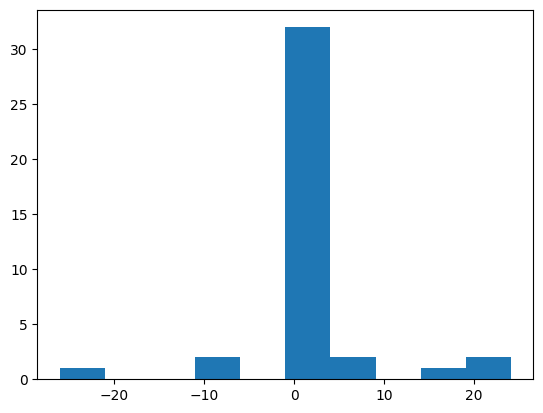

In [67]:
predictions = model.predict(data)
results = pd.DataFrame({'Actual': clinical_df['age_at_index'], 'Predicted': predictions})
errors = results['Actual'] - results['Predicted']
plt.hist(errors, bins=10)